In [16]:
import os
import numpy as np
import cv2
import pandas as pd
import matplotlib.pyplot as plt
import pickle
import random
import time
import scipy.ndimage
import matplotlib.pylab as plt
import argparse
import tensorflow as tf
import seaborn as sns
import pylab as pl
import itertools
from sklearn.model_selection import train_test_split,cross_val_score,GridSearchCV
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix
from imutils import paths
import pylab as pl
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_curve, auc
from tqdm import tqdm
from sklearn.metrics import plot_confusion_matrix
from yellowbrick.classifier import ClassificationReport
from yellowbrick.classifier import ClassPredictionError
from yellowbrick.classifier import ROCAUC
from sklearn.preprocessing import LabelBinarizer
from skimage.feature import hog
from keras.utils import to_categorical
from keras.models import Sequential, load_model,Model
from keras.layers import *
from keras.optimizers import *
from keras.applications import *
from tensorflow import keras
from PIL import Image
from matplotlib import pyplot


In [ ]:
#sharpening filter
filter = np.array([[-1, -1, -1], [-1, 9, -1], [-1, -1, -1]])

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [27]:
dir=r'/content/drive/My Drive/ML_Dataset'

In [5]:
categories=['1','2','3','4','5','6','7','8']

In [33]:
data=[]

def create_data():
    for category in categories:
        path=os.path.join(dir,category)
        label=categories.index(category)

        for img in tqdm(os.listdir(path)):
                
                
            try:
                imgpath=os.path.join(path,img)
                Sign_img=cv2.imread(imgpath,cv2.IMREAD_UNCHANGED)
                Sign_img=cv2.resize(Sign_img,(32,32))
                #UPSAMPLING
                ups_img=scipy.ndimage.zoom(Sign_img,(2,2,1), order=3)
                #PREPROCESSING
                #fil_img=cv2.filter2D(hog_desc,-1,filter)
                fil_img = np.hstack([cv2.GaussianBlur(ups_img,(5,5),0)]) #smoothing filter
                #HOG
                hog_desc = hog(fil_img, orientations=9, pixels_per_cell=(8, 8),cells_per_block=(2, 2), transform_sqrt=True, block_norm='L2-Hys')
                
                image=np.array(hog_desc).flatten()
                data.append([image,label])
            except Exception as e:
                pass

In [34]:
create_data()

print(len(data))

random.shuffle(data)
features=[]
labels=[]

for feature,label in data:
    features.append(feature)
    labels.append(label)


xtrain,xtest,ytrain,ytest=train_test_split(features,labels,test_size=0.25)

100%|██████████| 1260/1260 [00:33<00:00, 37.58it/s]

11393


In [35]:
# Transforming non numerical labels into numerical labels
encoder = preprocessing.LabelEncoder()

# encoding train labels 
encoder.fit(ytrain)
Y_train = encoder.transform(ytrain)

# encoding test labels 
encoder.fit(ytest)
Y_test = encoder.transform(ytest)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(xtrain)
X_test_scaled = scaler.transform(xtest)

model=SVC(C=8,kernel='rbf',gamma=0.0001)
model.fit(X_train_scaled, Y_train)

Y_pred = model.predict(X_test_scaled)
Y_pred_label = list(encoder.inverse_transform(Y_pred))

print(confusion_matrix(ytest,Y_pred_label))
print("\n")
print(classification_report(ytest,Y_pred_label))

print("Testing  set score for SVM: %f" % model.score(X_test_scaled  , Y_test ))
print("\n")

print("Training  set score for SVM: %f" % model.score(X_train_scaled  , Y_train ))

[[ 51   1   0   0   0   0   0   0]
 [  0 453   4   2   0   2   0   0]
 [  0   9 467   3   0   4   1   1]
 [  0   2   8 289   0   9   0   0]
 [  0   0   2   0 468   2   1   1]
 [  0  12   9   1   1 401   1   0]
 [  0   0   1   0   1   0 325   7]
 [  0   0   0   0   0   2   3 305]]


              precision    recall  f1-score   support

           0       1.00      0.98      0.99        52
           1       0.95      0.98      0.97       461
           2       0.95      0.96      0.96       485
           3       0.98      0.94      0.96       308
           4       1.00      0.99      0.99       474
           5       0.95      0.94      0.95       425
           6       0.98      0.97      0.98       334
           7       0.97      0.98      0.98       310

    accuracy                           0.97      2849
   macro avg       0.97      0.97      0.97      2849
weighted avg       0.97      0.97      0.97      2849

Testing  set score for SVM: 0.968410


Training  set score for SVM

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


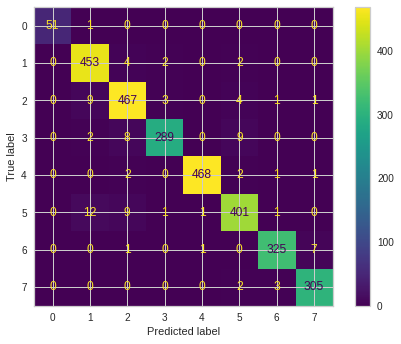

In [36]:
#plot confusion matrix
plot_confusion_matrix(model, X_test_scaled, Y_test)
plt.show()

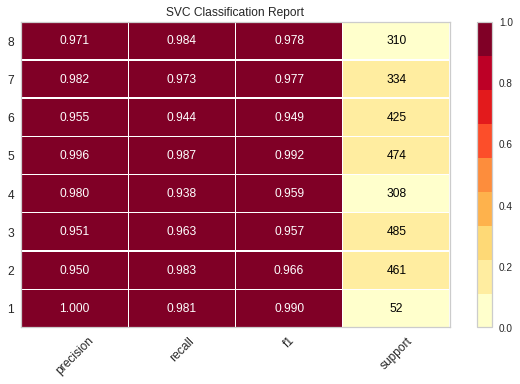

In [37]:
#plot classification report
classes=['1','2','3','4','5','6','7','8']
visualizer = ClassificationReport(model, classes=classes, support=True)

visualizer.fit(X_train_scaled, Y_train)        # Fit the visualizer and the model
visualizer.score(X_test_scaled, Y_test)        # Evaluate the model on the test data
visualizer.show()  

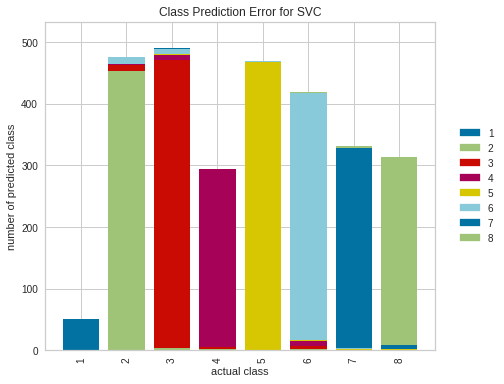

In [38]:
#plot class prediction error

visualizer = ClassPredictionError(model, classes=classes)

visualizer.fit(X_train_scaled, Y_train)        # Fit the visualizer and the model
visualizer.score(X_test_scaled, Y_test)        # Evaluate the model on the test data
visualizer.show()

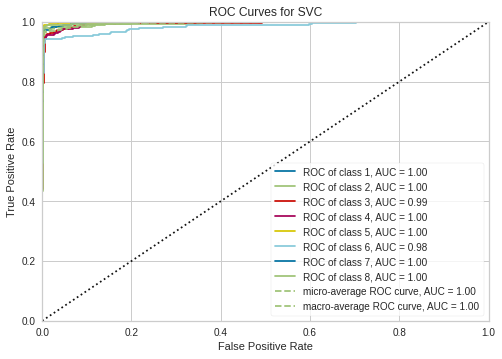

In [39]:
#plot ROC AUC
visualizer = ROCAUC(model, classes=classes)

visualizer.fit(X_train_scaled, Y_train)        # Fit the visualizer and the model
visualizer.score(X_test_scaled, Y_test)        # Evaluate the model on the test data
visualizer.show()